In [69]:
%matplotlib notebook
#%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import sys
import math
import h5py
import argparse
import importlib
import data_utils
import numpy as np
import tensorflow as tf
from datetime import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import scipy.spatial as spatial
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

from matplotlib import colors as mcolors
from sklearn.cluster import DBSCAN
from matplotlib import animation

import numpy as np


In [70]:

point_size=0.2
axes_str = ["X", "Y", "Z"]
random_color_box = [ _r for _r in mcolors.CSS4_COLORS]
color_map = ["#CFCDC9", "b","r","g"]
axes_limits = [
   [-100, 80], # X axis range
     [-10, 10], # Y axis range
     [-3, 10]   # Z axis range
 ] 

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):

    
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        plt.plot(vertices[ connection[0], :],vertices[ connection[1], :], c=color, lw=0.5)

        
def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    
    #class_color =  [color_map[int(i)] for i in velo_frame[:, 3]] 
    
  
    class_color =  [random_color_box[int(i)] for i in velo_frame[:, 4]] 
    
    point_sizes =  [ 0.01 if i < 1 else point_size for i in velo_frame[:, 3]] 

    ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_sizes,  c=class_color, cmap='gray')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
   
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)





In [71]:
filelist = "/home/hasan/data/hdd8TB/KITTI/3D-object-detection/dataset/random-XYZ-grid-0.25/val/val_zero_0random-XYZ-grid-0.25_pred.h5"
data = h5py.File(filelist)
data_num = data['data_num'][...].astype(np.float32)

confidence = data['confidence'][...].astype(np.float32)
label_seg = data['label_seg'][...].astype(np.int64)
data.keys()



[u'confidence',
 u'data',
 u'data_num',
 u'indices_split_to_full',
 u'label_seg',
 u'original_label']

In [72]:
filelist = "/home/hasan/data/hdd8TB/KITTI/3D-object-detection/dataset/random-XYZ-grid-0.25/val/val_zero_0.h5"
data = h5py.File(filelist)
data_train = data['data'][:,:,:].astype(np.float32)
label = data['label'][...].astype(np.int32)
label_train = data['label_seg'][...].astype(np.int64)
data_num_train = data['data_num'][...].astype(np.int32)
data.keys()
#print(data_num_train.shape, data_num_train,)
#print(np.unique(label, return_counts=True) )

[u'data', u'data_num', u'indices_split_to_full', u'label', u'label_seg']

In [78]:
data_frame = []
label_frame = []
confidence_frame = []
indices = np.nonzero(label==5578)


(array([3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074,
        3075, 3076]),)

In [94]:
for i in  indices[0]:
    
    data_frame.append(data_train[i,:data_num_train[i]])
    label_frame.append(label_seg[i,:data_num_train[i]])
    confidence_frame.append(confidence[i,:data_num_train[i]])

    

labels = np.concatenate(label_frame)
print(labels)
labels = labels.astype(int)
labels

[0 0 0 ... 0 0 0]


array([0, 0, 0, ..., 0, 0, 0])

In [89]:
velo_frame = np.concatenate(data_frame)[:,:3]
confidence_filter= np.concatenate(confidence_frame)
print(velo_frame.shape, confidence_filter.shape)

velo_frame = velo_frame[ np.logical_and(labels >= 1, velo_frame[:,0] >= -100)  ]

confidence_filter = confidence_filter[labels >=1]
labels = labels[labels >=1]
print(velo_frame.shape)

print(np.amax(velo_frame, axis=0))
print(np.amin(velo_frame, axis=0))

#DBSCAN

clustering = DBSCAN(eps=1, min_samples=350).fit(velo_frame)
_inidices = clustering.labels_ > -1
object_ids = clustering.labels_
print(_inidices.shape, np.unique(clustering.labels_[_inidices], return_counts=True))
velo_frame

(881762, 3) (881762,)
(94689, 3)
[57.658  0.391 11.337]
[-1.046 -1.821 -8.242]
(94689,) (array([0, 1, 2, 3, 4, 5, 6]), array([36057, 30660,  6391, 13237,  6167,   665,   371]))


array([[ 0.626, -0.677, -3.001],
       [ 5.72 , -0.65 ,  3.883],
       [23.261, -0.543, -1.955],
       ...,
       [ 5.428, -0.761,  3.701],
       [ 3.551, -1.025, -2.031],
       [ 1.541, -0.359, -2.248]], dtype=float32)

In [90]:
velo_frame

array([[ 0.626, -0.677, -3.001],
       [ 5.72 , -0.65 ,  3.883],
       [23.261, -0.543, -1.955],
       ...,
       [ 5.428, -0.761,  3.701],
       [ 3.551, -1.025, -2.031],
       [ 1.541, -0.359, -2.248]], dtype=float32)

(94689, 3) (94689, 1)
(94689, 5)


<IPython.core.display.Javascript object>


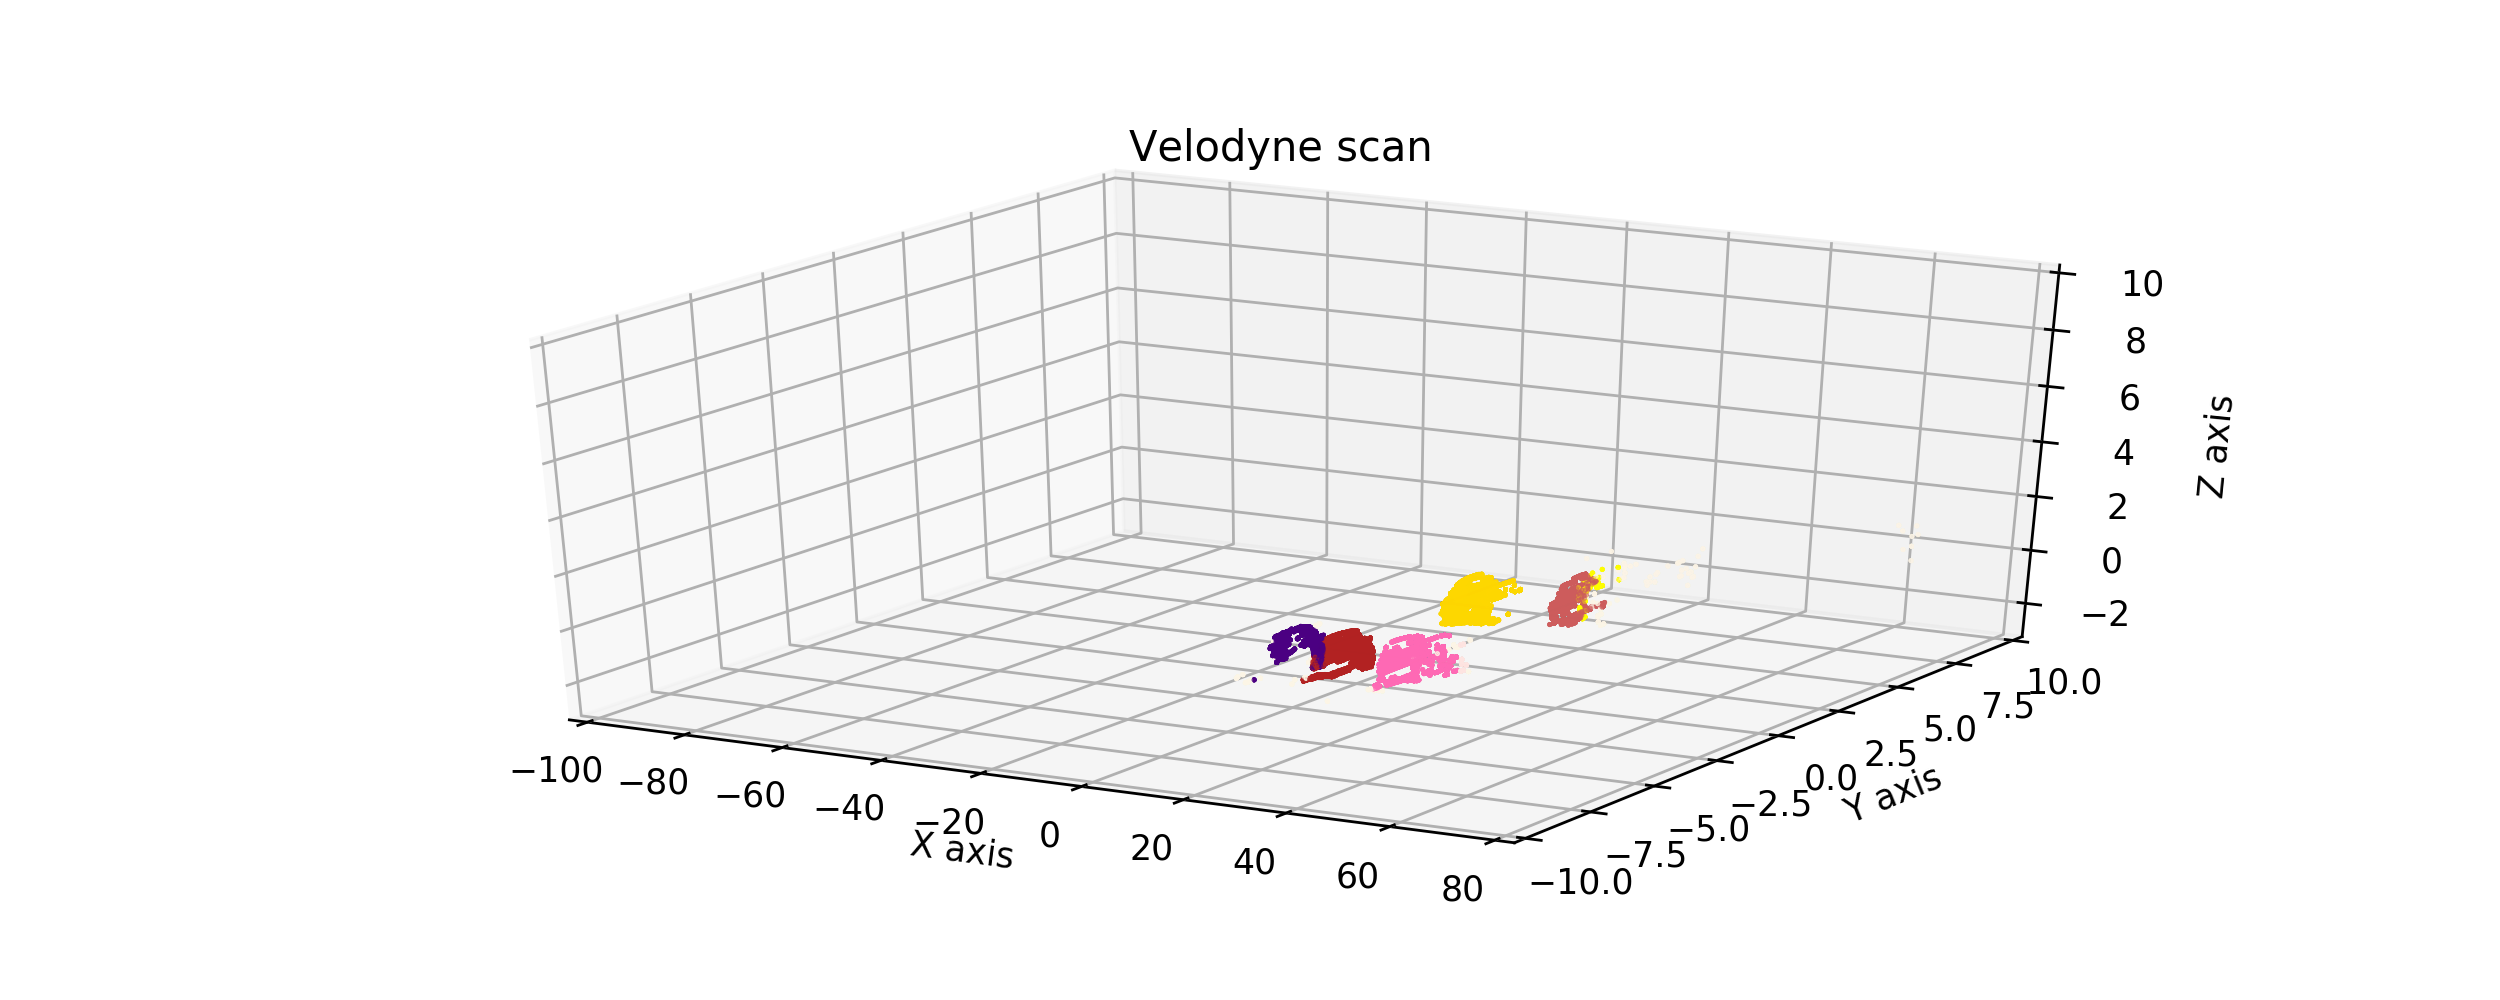

In [91]:
id_frame =6
#labels, velo_frame = label_train[id_frame, :data_num_train[id_frame]], data_train[id_frame, :data_num_train[id_frame],:]
labels = np.expand_dims(labels, axis=1)
object_ids = np.expand_dims(object_ids, axis=1)
print(velo_frame.shape, labels.shape)
pointSize = velo_frame.shape[0]
# X, Y, Z, Class, Object_id
velo_frame = np.concatenate( (velo_frame[:,0:1],velo_frame[:,2:3], velo_frame[:,1:2],labels, object_ids) , axis=1)
obj_id = 1

#velo_frame = velo_frame[ np.logical_and(labels >= 1, velo_frame[:,0] >= -100)  ] #load_data#[ load_data[:,3] >= 1 ] #np.logical_and(load_data[:,3] >= 1,  load_data[:,-1]==30) ]
#velo_frame = np.append(velo_frame, [np.amax(velo_frame, axis=0), np.amin(velo_frame, axis=0)], axis=0)

#velo_frame = velo_frame[_inidices]

print(velo_frame.shape)

f2 = plt.figure(figsize=(10,4))
axes=[0, 1, 2]
ax2 = f2.add_subplot(111, projection='3d')   
order_ids = np.arange(8)
draw_point_cloud(ax2, 'Velodyne scan', xlim3d=None)
plt.show()